# Load library

In [1]:
import os
if not os.getcwd().endswith('m6A'):
    os.chdir('m6A/')
%load_ext rpy2.ipython
from scripts.common import *

%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin
data_folder='/home/dengw1/workspace/mouse_lowinput/'
RBP_peak='./validation/eCLIP/U8.combined.merged.bed'

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin


In [2]:
%%R
source('scripts/common.r')
data_folder<-'/home/dengw1/workspace/mouse_lowinput/'

# Prepare eCLIP peaks

In [ ]:
%%bash
mkdir -p validation/eCLIP
cat ~/workspace/mouse_lowinput/U8eCLIP/clam/peaks/peaks-U8-Rep1-IP__U8-Rep1-Inp/narrow_peak.combined.bed > ./validation/eCLIP/U8.combined.bed
cat ~/workspace/mouse_lowinput/U8eCLIP/clam/peaks/peaks-U8-Rep2-IP__U8-Rep2-Inp/narrow_peak.combined.bed >> ./validation/eCLIP/U8.combined.bed
cat ~/workspace/mouse_lowinput/U8eCLIP/clam/peaks/peaks-U8-Rep3-IP__U8-Rep3-Inp/narrow_peak.combined.bed >> ./validation/eCLIP/U8.combined.bed
bedtools sort -i ./validation/eCLIP/U8.combined.bed > ./validation/eCLIP/U8.combined.sorted.bed
bedtools merge -s -c 4,5,6,7,8,9,10 -d -1 -o first,first,first,distinct,distinct,distinct,first -i ./validation/eCLIP/U8.combined.sorted.bed \ 
> ./validation/eCLIP/U8.combined.merged.bed

In [98]:
%%bash
mkdir -p validation/m6A
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8C-Rep1-IP__U8C-Rep1-Inp/narrow_peak.combined.bed > ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8C-Rep2-IP__U8C-Rep2-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8C-Rep3-IP__U8C-Rep3-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8F-Rep1-IP__U8F-Rep1-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8F-Rep2-IP__U8F-Rep2-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8F-Rep3-IP__U8F-Rep3-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8S-Rep1-IP__U8S-Rep1-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
cat ~/workspace/mouse_lowinput/FA300/clam/peaks/peaks-U8S-Rep2-IP__U8S-Rep2-Inp/narrow_peak.combined.bed >> ./validation/m6A/U8.combined.bed
bedtools sort -i ./validation/m6A/U8.combined.bed > ./validation/m6A/U8.combined.sorted.bed
bedtools merge -s -c 4,5,6,7,8,9,10 -d -1 -o first,first,first,distinct,distinct,distinct,first -i ./validation/m6A/U8.combined.sorted.bed > ./validation/m6A/U8.combined.merged.bed

# Figure S8A

In [58]:
fo=open('validation/eCLIP/fxr2_dist.txt','w')

# ret=subprocess.check_output('python3 scripts/Peak_distribution_on_utr_cds.py validation/eCLIP/U8.combined.merged.bed',shell=True).decode('utf-8')

info=ret.strip().split('\n')
for i in range(len(info)):
    fo.write('U87MG\t%s\t%s\n'%(i+1,info[i].split('\t')[0]))
fo.close()

df=pd.read_csv('validation/eCLIP/fxr2_dist.txt',sep='\t',header=None,names=['Group','X','Y'])

df.loc[df['Group']=='U87MG','Y']=list(df[df['Group']=='U87MG']['Y']/sum(df[df['Group']=='U87MG']['Y']))
df['Accumulate']=np.zeros(150)
df.iloc[0:150,3]=[sum(df.iloc[0:x+1,2]) for x in range(150)]

df.to_csv('validation/eCLIP/fxr2_dist.txt',sep='\t',index=False)

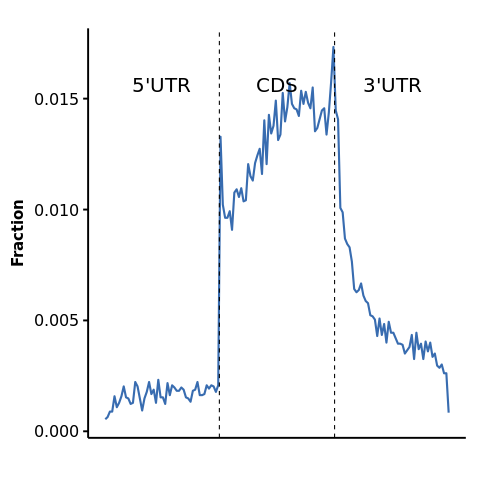

In [3]:
%%R
df_dist<-read.table('validation/eCLIP/fxr2_dist.txt',sep='\t',header=T,stringsAsFactors=T)

pdf('figures/Figure5_S8A_distribution.pdf',height=4.5)
sep1=50.5
sep2=100.5
p<-ggplot(df_dist,aes(x=X,y=Y,color=Group,group=Group))+geom_line(size=1)+
    geom_vline(xintercept=c(sep1, sep2), linetype='dashed', size = 0.5) +
  annotate('text', label=c("5'UTR", "CDS", "3'UTR"), size = 7,x=c( sep1/2, (sep1+sep2)/2, sep2+sep1/2 ),
           y=max(df_dist[,3])*0.9)  +
    ylab('Fraction')+xlab('Bin')+
    scale_colour_Publication()+ theme_Publication()+
    theme(panel.spacing = unit(0.5, 'lines'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
#         text = element_text(size=15),
#         axis.text.y = element_text(size=15),
        axis.title.y = element_text(size=15),
        legend.position = 'none',
        axis.ticks.x=element_blank(),
        axis.text.x=element_blank())+
    guides(color=guide_legend(ncol=1,title.position='top'))+xlab('')
print(p)
dev.off()
print(p)


# Figure 5A

In [56]:
regulators=['FXR2', 'METTL3', 'METTL14','WTAP', 'FTO', 'ALKBH5']
regulators.sort()
for sample in ['Inp', 'IP']:
    gene_exp = None
    for grp in ['U8C', 'U8F']:
        for rep in [1, 2, 3]:
            tmp_exp = pd.read_csv(
                f'{data_folder}FA300/kallisto/{grp}-Rep{rep}-{sample}/abundance.tsv', sep='\t', index_col=0, header=0)
            tmp_exp = tmp_exp.loc[:, ['tpm']]
            tmp_exp.columns = ['%s_%s' % (grp, rep)]
            if gene_exp is None:
                gene_exp = tmp_exp
            else:
                gene_exp = gene_exp.add(tmp_exp, fill_value=0)
        gene_exp[grp] = (gene_exp['%s_1' % grp]+gene_exp['%s_2' % grp])/2
#         gene_exp.drop(['%s_1' % grp, '%s_2' % grp], axis=1, inplace=True)
    gene_exp['tx']=[x.split('|')[0] for x in gene_exp.index]
    gene_exp['gene']=[x.split('|')[5] for x in gene_exp.index]
    gene_exp_merged = defaultdict(lambda: defaultdict(int))
    for tx in gene_exp.index:
        gene = tx.split('|')[5]
        for grp in [x for x in gene_exp.columns if x not in ['tx','gene']]:# ['U8C', 'U8F']:
            gene_exp_merged[gene][grp] += gene_exp.loc[tx, grp]
    gene_exp_merged = pd.DataFrame(gene_exp_merged).T
    print(gene_exp_merged.loc[regulators, :])
    
    exp_df=defaultdict(lambda :[])
    gene_list=regulators*2
    gene_list.sort()
    exp_df['Gene']=gene_list
    for gene in regulators:
        exp_df['Group'].append('siCTRL')
        exp_df['Group'].append('siFXR2')
        exp_df['TPM'].append(gene_exp_merged.loc[gene,'U8C'])
        exp_df['TPM'].append(gene_exp_merged.loc[gene,'U8F'])
        exp_df['SD'].append(statistics.stdev(gene_exp_merged.loc[gene,['U8C_1','U8C_2','U8C_3']]))
        exp_df['SD'].append(statistics.stdev(gene_exp_merged.loc[gene,['U8F_1','U8F_2','U8F_3']]))
    pd.DataFrame(exp_df).to_csv('validation/regulator_exp_%s.txt'%sample,sep='\t',header=True,index=False)
    [gene_exp_merged.drop(['%s_1' % grp, '%s_2' % grp, '%s_3' % grp], axis=1, inplace=True) for grp in ['U8C', 'U8F']]
    
    gene_exp_merged.columns = ['siCTRL', 'siFXR2']
    gene_exp_merged.to_csv(
        'm6A_data/FA300_gene_exp_mean_%s.csv' % sample, sep='\t')

#     gene_exp.index = gene_exp['tx']
#     gene_exp.to_csv('m6A_data/FA300_tx_exp_mean_%s.csv' % sample, sep='\t')


               U8C      U8C_1      U8C_2      U8C_3      U8F_1      U8F_2  \
ALKBH5   30.007848  32.871170  27.144526  34.045732  36.241910  35.321850   
FTO      31.467509  30.290590  32.644428  26.773081  32.020291  36.907636   
FXR2     45.722690  51.546900  39.898480  58.192621  10.104200  10.804500   
METTL14   8.367304   5.061849  11.672760  12.643520   5.774759  10.280910   
METTL3   30.465495  32.144782  28.786208  33.821268  28.782572  24.572700   
WTAP     23.552250  21.044940  26.059560  52.829060  15.734801  23.607230   

             U8F_3        U8F  
ALKBH5   37.917100  35.781880  
FTO      26.645971  34.463963  
FXR2     20.805323  10.454350  
METTL14   9.769511   8.027835  
METTL3   28.650399  26.677636  
WTAP     47.603040  19.671016  
               U8C      U8C_1      U8C_2       U8C_3      U8F_1      U8F_2  \
ALKBH5   30.904919  32.937274  28.872565   28.693900  30.886837  29.527900   
FTO      37.550708  37.905745  37.195672   34.545287  38.954653  42.218088   
FX

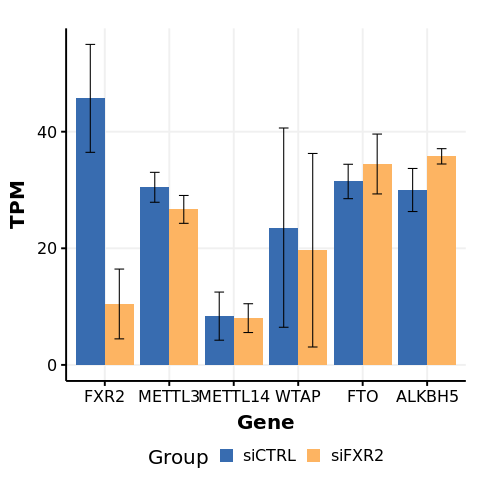

In [59]:
%%R
exp <- read.csv('validation/regulator_exp_Inp.txt', sep='\t', header=1)
exp$Gene <- factor(exp$Gene,levels=c('FXR2', 'METTL3', 'METTL14','WTAP', 'FTO', 'ALKBH5'))
pdf('figures/Figure5A.pdf',width=8)
p<-ggplot(exp, aes(x=Gene, y=TPM, fill=Group,group=Group))+
geom_bar(stat='identity',position=position_dodge())+geom_errorbar(aes(x=Gene,ymin=TPM-SD,ymax=TPM+SD),position=position_dodge(width=0.9),width=0.3)+
theme_Publication()+scale_fill_Publication()
print(p)
dev.off()
print(p)

# Figure5B

In [4]:
peak_intensity = pd.read_csv(
    'm6A_data/peak_intensity_u8_clam.csv', sep='\t', index_col=0)
samples = list(set([x.split('-')[0] for x in peak_intensity.columns]))
samples=[x  for x in samples if not x.startswith('U8S')]
for sample in samples:
    peak_intensity[sample] = gmean(
        [peak_intensity['%s-Rep1' % sample], peak_intensity['%s-Rep2' % sample], peak_intensity['%s-Rep3' % sample]], axis=0)
    peak_intensity.drop(
        columns=['%s-Rep1' % sample, '%s-Rep2' % sample, '%s-Rep3' % sample], inplace=True)
peak_intensity['FFC'] = np.log2(peak_intensity['U8F']/peak_intensity['U8C'])
peak_intensity.to_csv('m6A_data/peak_intensity_u8_clam_fc.csv', sep='\t')

up_regulated = pd.DataFrame(
    [x.split(':') for x in peak_intensity[peak_intensity.FFC > 0].index])
down_regulated = pd.DataFrame(
    [x.split(':') for x in peak_intensity[peak_intensity.FFC < 0].index])
up_regulated.columns = ['chr', 'start', 'end', 'strand']
down_regulated.columns = ['chr', 'start', 'end', 'strand']
up_regulated['info'] = down_regulated['info'] = '.'
up_regulated['score'] = down_regulated['score'] = '.'
up_regulated = BedTool.from_dataframe(
    up_regulated[['chr', 'start', 'end', 'info', 'score', 'strand']])
down_regulated = BedTool.from_dataframe(
    down_regulated[['chr', 'start', 'end', 'info', 'score', 'strand']])
a = len(up_regulated.intersect(BedTool(RBP_peak),u=True, wa=True, s=True))
b = len(up_regulated)
c = len(down_regulated.intersect(BedTool(RBP_peak),u=True, wa=True, s=True))
d = len(down_regulated)

print(a, b-a, c, d-c)
print(fisher_exact([[a, b-a], [c, d-c]]))

all_u8_peaks = pd.DataFrame([x.split(':') for x in peak_intensity.index])
all_u8_peaks.columns = ['chr', 'start', 'end', 'strand']
all_u8_peaks['info'] = '.'
all_u8_peaks['score'] = '.'
all_u8_peaks = BedTool.from_dataframe(
    all_u8_peaks[['chr', 'start', 'end', 'info', 'score', 'strand']])
all_u8_peaks.saveas('ts_data/all_u8_peak.bed')

1606 21504 852 15072
(1.3211665828303152, 1.266910618788352e-10)


<BedTool(ts_data/all_u8_peak.bed)>

In [5]:
peak_intensity = pd.read_csv(
    'm6A_data/peak_intensity_u8_clam_fc.csv', sep='\t', index_col=0)

cmd = '''
bedtools intersect -a ts_data/all_u8_peak.bed\
    -b {peak} -wa -u > WGCNA/{RBP}_all_u8_intersect.bed

cat WGCNA/{RBP}_all_u8_intersect.bed | sort |uniq > WGCNA/{RBP}_all_u8_intersect_uniq.bed
rm WGCNA/{RBP}_all_u8_intersect.bed
bedtools subtract -a ts_data/all_u8_peak.bed  \
    -b {peak} > WGCNA/{RBP}_subtract_all_u8_tmp.bed
cat WGCNA/{RBP}_subtract_all_u8_tmp.bed | sort |uniq > WGCNA/{RBP}_all_u8_subtract.bed
rm WGCNA/{RBP}_subtract_all_u8_tmp.bed
'''
## all peak2gene of FXR2 peak to peak2gene.txt
peak2gene={":".join([x[0],x[1],x[2],x[5]]):x[3].split('-')[0] for x in [y.strip().split('\t') for y in open('validation/m6A/U8.combined.merged.bed')]}
fxr2peaks={":".join([x[0],x[1],x[2],x[5]]):x[3].split('-')[0] for x in [y.strip().split('\t') for y in open('validation/eCLIP/U8.combined.merged.bed')]}
peak2gene.update(fxr2peaks)
with open('validation/peak2gene_all.txt','w') as fo:
    for key in peak2gene:
        fo.write('%s\t%s\n'%(key,peak2gene[key]))
    fo.close()

subprocess.call(cmd.format(RBP='FXR2',peak=RBP_peak), shell=True)
peaks = pd.read_csv('WGCNA/FXR2_all_u8_intersect_uniq.bed', sep='\t', header=None).iloc[:, [
        0, 1, 2, 5]].agg(lambda x: ':'.join(x.dropna().astype(str)), axis=1).to_list()
peak_intensity=peak_intensity.loc[[x in peak2gene.keys() for x in list(peak_intensity.index)],:]
group=[]
for peak in peak_intensity.index:
    if peak in peaks:
        group.append('FXR2')
    elif peak2gene[peak] in fxr2peaks.values():
        group.append('SameGene')
    else:
        group.append('BG')
peak_intensity['FXR2_clip'] =group

peak_intensity.to_csv('m6A_data/peak_intensity_u8_clam_fc_samegene.csv', sep='\t')
# peak_intensity=peak_intensity.loc[peak_intensity['FFC'] != 0,:]

In [119]:
ensg_gn={x[0]:x[1] for x in [y.strip().split('\t') for y in open('gtf/ensg_gn.txt')]}
exp=pd.read_csv('m6A_data/FA300_gene_exp_mean_Inp.csv', sep='\t', index_col=0, header=0)
exp['FFC']=(exp['siFXR2']+1)/(exp['siCTRL']+1)
exp['FFC']=np.log2(exp['FFC'])
siCTRL=[]
siFXR2=[]
FFC_exp=[]
gn=[]
ensg=[]
for x in peak_intensity.index:
    if (x in peak2gene and peak2gene[x] in ensg_gn and ensg_gn[peak2gene[x]] in exp.index):
        siCTRL.append(exp.loc[ensg_gn[peak2gene[x]],'siCTRL'])
        siFXR2.append(exp.loc[ensg_gn[peak2gene[x]],'siFXR2'])
        FFC_exp.append(exp.loc[ensg_gn[peak2gene[x]],'FFC'])
        gn.append(ensg_gn[peak2gene[x]])
        ensg.append(peak2gene[x])
    else:
        siCTRL.append(-1)
        siFXR2.append(-1)
        FFC_exp.append(0)
        gn.append('NA')
        ensg.append('NA')

peak_intensity['U8C_exp']=siCTRL
peak_intensity['U8F_exp']=siFXR2
peak_intensity['FFC_exp']=FFC_exp
peak_intensity['GN']=gn
peak_intensity['ENSG']=ensg

In [220]:
candidates=peak_intensity.loc[peak_intensity['FXR2_clip']=='SameGene',:].sort_values(by='FFC',ascending=False)
candidates['Region']=['%s:%s-%s'%(x[0],x[1],x[2]) for x in [y.split(':') for y in candidates.index]]
candidates[['chr','start','end','strand']]=[y.split(':') for y in candidates.index]
candidates=candidates.loc[candidates['FFC_exp']<0,:].head(n=40)

## Get exonic sequence of up-stream and down-stream of selected candidates

In [209]:
cmd='''cat gtf/hg19.gtf| grep '^chr'| awk '{if($3=="exon"){print}}'| grep -v 'retained_intron' \
| awk '{split($12,a,"ENST");split(a[2],b,".");printf("%s\\t%s\\t%s\\tENST%s\\t.\\t%s\\n",$1,$4-1,$5,b[1],$7)}' > gtf/exons_wo_retained_intron.bed'''
print(cmd)

cat gtf/hg19.gtf| grep '^chr'| awk '{if($3=="exon"){print}}'| grep -v 'retained_intron' | awk '{split($12,a,"ENST");split(a[2],b,".");printf("%s\t%s\t%s\tENST%s\t.\t%s\n",$1,$4-1,$5,b[1],$7)}' > gtf/exons_wo_retained_intron.bed


In [221]:
cmd='''cat gtf/hg19.gtf| grep '^chr'| awk '{if($3=="exon"){print}}'| grep -v 'retained_intron' \
| awk '{split($12,a,"ENST");split(a[2],b,".");printf("%s\\t%s\\t%s\\tENST%s\\t.\\t%s\\n",$1,$4-1,$5,b[1],$7)}' > gtf/exons_wo_retained_intron.bed'''
subprocess.call(cmd,shell=True)
gene_tx_seq=defaultdict(list)
gene_longest_tx_seq={}
seq=''
ensg=''
for line in open('gtf/hg19.tx.fasta'):
    if line.startswith('>'):
        if len(seq)>0:
            if ensg not in gene_longest_tx_seq or len(seq)>len(gene_longest_tx_seq[ensg]):
                gene_longest_tx_seq[ensg]=seq
            gene_tx_seq[ensg].append(seq)
            seq=''
        ensg=line.split('|')[1].split('.')[0]
    else:
        seq+=line.strip()
if ensg not in gene_longest_tx_seq or len(seq)>gene_longest_tx_seq[ensg]:
                gene_longest_tx_seq[ensg]=seq
gene_tx_seq[ensg].append(seq)
ensg_enst=defaultdict(list)
for line in open('gtf/hg19.gtf'):
    if line.startswith('chr'):
        info=line.strip().split('\t')[-1].split(';')
        enst=info[1].split('"')[1].split('.')[0]
        ensg=info[0].split('"')[1].split('.')[0]
        if 'retained_intron' not in line:
            ensg_enst[ensg].append(enst)
candidate_bed=pd.DataFrame([x.split(':') for x in candidates.index],columns=['chrom','start','end','name'])
candidate_bed['score']=100
candidate_bed['strand']=candidate_bed['name']
candidate_bed=BedTool.from_dataframe(candidate_bed)
exons=pd.read_csv('gtf/exons_wo_retained_intron.bed',sep='\t',header=None,names=['chr','start','end','info','score','strand'])

def correct_exonic_region(org_region,gene):
    valid_exons=exons.loc[exons['info'].isin(ensg_enst[gene]),:]
    valid_exons=BedTool.from_dataframe(valid_exons)
    valid_exons=valid_exons.sort()
    valid_exons=valid_exons.merge()
    peak=BedTool('\t'.join(org_region),from_string=True)
    peak=peak.intersect(valid_exons)
    
    peak_seq=open(peak.sequence(fi='gtf/hg19.fasta',s=True).seqfn).read().split('\n')
    if len(peak_seq)<2:
        return peak_seq
    peak_seq=peak_seq[1].strip()[1:-1]
    tx_seq=gene_longest_tx_seq[gene].split(peak_seq)
    if len(tx_seq)<2:
        for seq in gene_tx_seq[gene]:
            tx_seq=seq.split(peak_seq)
            if len(tx_seq)>=2:
                break
    if len(tx_seq)<2:
        return peak_seq+':'+tx_seq[0]
    
    up_len=100-int(len(peak_seq)/2)
    down_len=300-up_len-len(peak_seq)
    return tx_seq[0][-up_len:]+peak_seq+tx_seq[1][0:down_len]


seq=[]
for i in range(len(candidates)):   
    region=list(candidates.iloc[i,[12,13,14,10,11,15]])
    gene=candidates.iloc[i,10]
    seq.append(correct_exonic_region(region,gene))
candidates['Seq']=seq

candidates.to_csv('validation/qpcr_candidates.txt',sep='\t')

png 
  2 


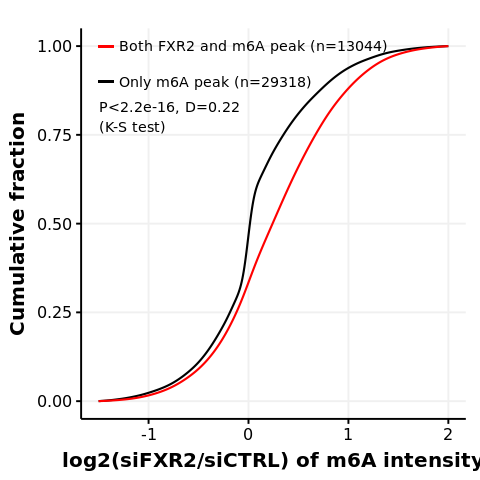

In [4]:
%%R
df <- read.csv('m6A_data/peak_intensity_u8_clam_fc_samegene.csv',sep='\t',header=T,
    row.names=1,stringsAsFactors=F)

ks_test<-ks.test(df[df$FXR2_clip!="BG",]$FFC,df[df$FXR2_clip=="BG",]$FFC)
dens1 = density(df[df$FXR2_clip=="BG",]$FFC, adjust=1, from=-1.5, to=2)
dens1 = data.frame(x=dens1$x, y=dens1$y)
dens2 = density(df[df$FXR2_clip!="BG",]$FFC, adjust=1, from=-1.5, to=2)
dens2 = data.frame(x=dens2$x, y=dens2$y)

# dens3 = density(df[df$FXR2_clip=="SameGene",]$FFC, adjust=1, from=-1.5, to=2)
# dens3 = data.frame(x=dens3$x, y=dens3$y)

p <-ggplot(dens1,aes(x=x))+theme_Publication()+scale_fill_Publication()+
geom_line(data=dens1, aes(x=x, y=cumsum(y)/sum(y)), color="black", size=1) +
geom_line(data=dens2, aes(x=x, y=cumsum(y)/sum(y)), color="red", size=1) +
# geom_line(data=dens3, aes(x=x, y=cumsum(y)/sum(y)), color="blue", size=1) +

annotate('text',label=paste0('Both FXR2 and m6A peak (n=',nrow(df[df$FXR2_clip!="BG",]),')'),x=-1.3,y=1,hjust=0,size=5)+
annotate('text',label=paste0('Only m6A peak (n=',nrow(df[df$FXR2_clip=="BG",]),')'),x=-1.3,y=0.9,hjust=0,size=5)+
geom_segment(x = -1.5, xend = -1.35, y = 1,yend = 1,color = 'red', size = 1,lty=1)+
geom_segment(x = -1.5, xend = -1.35, y = 0.9,yend = 0.9,color = 'black', size = 1,lty=1)+
annotate('text',label=paste0('P<2.2e-16, D=',format(ks_test$statistic,scientific=F,digits=2),' \n(K-S test)'),x=-1.5,y=0.8,hjust=0,size=5)+
ylab('Cumulative fraction')+xlab('log2(siFXR2/siCTRL) of m6A intensity')
print(p)
pdf('figures/Figure5B.pdf')
print(p)
dev.off()

png 
  2 


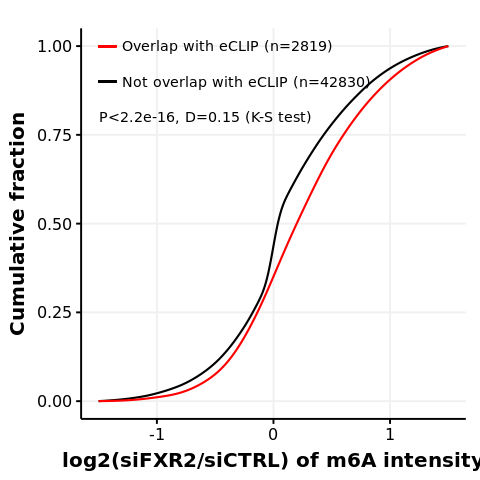

In [60]:
%%R
## Older version with Overlap/non-overlap stratification
df <- read.csv('m6A_data/peak_intensity_u8_clam_fc.csv',sep='\t',header=T,
    row.names=1,stringsAsFactors=F)

ks_test<-ks.test(df[df$FXR2_clip=="FXR2",]$FFC,df[df$FXR2_clip=="BG",]$FFC)
dens1 = density(df[df$FXR2_clip=="BG",]$FFC, adjust=1, from=-1.5, to=1.5)
dens1 = data.frame(x=dens1$x, y=dens1$y)
dens2 = density(df[df$FXR2_clip=="FXR2",]$FFC, adjust=1, from=-1.5, to=1.5)
dens2 = data.frame(x=dens2$x, y=dens2$y)

p <-ggplot(dens1,aes(x=x))+theme_Publication()+scale_fill_Publication()+
geom_line(data=dens1, aes(x=x, y=cumsum(y)/sum(y)), color="black", size=1) +
geom_line(data=dens2, aes(x=x, y=cumsum(y)/sum(y)), color="red", size=1) +
annotate('text',label=paste0('Overlap with eCLIP (n=',nrow(df[df$FXR2_clip=="FXR2",]),')'),x=-1.3,y=1,hjust=0,size=5)+
annotate('text',label=paste0('Not overlap with eCLIP (n=',nrow(df[df$FXR2_clip=="BG",]),')'),x=-1.3,y=0.9,hjust=0,size=5)+
geom_segment(x = -1.5, xend = -1.35, y = 1,yend = 1,color = 'red', size = 1,lty=1)+
geom_segment(x = -1.5, xend = -1.35, y = 0.9,yend = 0.9,color = 'black', size = 1,lty=1)+
annotate('text',label=paste0('P<2.2e-16, D=',format(ks_test$statistic,scientific=F,digits=2),' (K-S test)'),x=-1.5,y=0.8,hjust=0,size=5)+
ylab('Cumulative fraction')+xlab('log2(siFXR2/siCTRL) of m6A intensity')
print(p)
pdf('figures/Figure5B.pdf')
print(p)
dev.off()

# Figure5E

In [55]:
exp=pd.read_csv('m6A_data/FA300_gene_exp_mean_Inp.csv', sep='\t', index_col=0, header=0)
exp['FFC']=(exp['siFXR2']+1)/(exp['siCTRL']+1)
exp['FFC']=np.log2(exp['FFC'])

ensg_gn={x[0]:x[1] for x in [x.strip().split('\t') for x in open('m6A_data/ensg_gn.txt')]}
gene_region=pd.read_csv('gtf/genes.bed',sep='\t',index_col=None,header=None)
gene_region.columns=['chr','start','end','gene','score','strand']

m6A_peaks=[]
for rep in ['1','2','3']:
    m6A_peaks.extend(open(f'{data_folder}FA300/clam/peaks/peaks-U8C-Rep{rep}-IP__U8C-Rep{rep}-Inp/narrow_peak.combined.bed').readlines())

m6A_peaks=BedTool(''.join(m6A_peaks),from_string=True).sort()
m6A_peaks=m6A_peaks.merge(s=True,d=-100,c='4,5,6',o='first,first,first')
m6A_peaks=m6A_peaks.to_dataframe()
m6A_peaks.columns=['chr','start','end','gene','score','strand']
m6A_peaks['gene']=[x.split('-')[0] for x in m6A_peaks['gene']]

exp['Peak_num']=0
for i in range(len(gene_region)):
    gene=gene_region.iloc[i]['gene']
    peak_num=len(m6A_peaks.loc[m6A_peaks['gene']==gene,:])
    if gene in ensg_gn and ensg_gn[gene] in exp.index:
        exp.loc[ensg_gn[gene],'Peak_num']=peak_num
        

fxr2_peaks=[]
for rep in ['1','2','3']:
    fxr2_peaks.extend(open(f'{data_folder}U8eCLIP/clam/peaks/peaks-U8-Rep{rep}-IP__U8-Rep{rep}-Inp/narrow_peak.combined.bed').readlines())

fxr2_peaks=BedTool(''.join(fxr2_peaks),from_string=True).sort()
fxr2_peaks=fxr2_peaks.merge(s=True,d=-100,c='4,5,6',o='first,first,first')
fxr2_peaks=fxr2_peaks.to_dataframe()
fxr2_peaks.columns=['chr','start','end','gene','score','strand']
fxr2_peaks['gene']=[x.split('-')[0] for x in fxr2_peaks['gene']]

exp['FXR2_peak_num']=0
for i in range(len(gene_region)):
    gene=gene_region.iloc[i]['gene']
    peak_num=len(fxr2_peaks.loc[fxr2_peaks['gene']==gene,:])
    if gene in ensg_gn and ensg_gn[gene] in exp.index:
        exp.loc[ensg_gn[gene],'FXR2_peak_num']=peak_num

for i in range(len(exp)):
    if exp.loc[exp.index[i],'FXR2_peak_num']==0 and exp.loc[exp.index[i],'Peak_num']==0:
        exp.loc[exp.index[i],'Group']='Neither'
    elif exp.loc[exp.index[i],'FXR2_peak_num']==0:
        exp.loc[exp.index[i],'Group']='m6A'
    elif exp.loc[exp.index[i],'Peak_num']==0:
        exp.loc[exp.index[i],'Group']='FXR2'
    else:
        exp.loc[exp.index[i],'Group']='Both'

exp.to_csv('WGCNA/siFXR2_exp.txt',sep='\t')

fxr2_peaks['gene']=[ensg_gn[x] if x in ensg_gn else 'NA' for x in fxr2_peaks['gene']]
m6A_peaks['gene']=[ensg_gn[x] if x in ensg_gn else 'NA' for x in m6A_peaks['gene']]
fxr2_peaks=fxr2_peaks.loc[fxr2_peaks['gene'].isin(exp.loc[exp['Group']=='Both',:].index),:]
m6A_peaks=m6A_peaks.loc[m6A_peaks['gene'].isin(exp.loc[exp['Group']=='Both',:].index),:]
if not os.path.isdir('validation/Figure5'):
    os.mkdir('validation/Figure5')
fxr2_peaks.to_csv('validation/Figure5/FXR2_both.bed',sep='\t',index=False,header=None)
m6A_peaks.to_csv('validation/Figure5/m6A_both.bed',sep='\t',index=False,header=None)

In [18]:
ensg_gn={x[0]:x[1] for x in [y.strip().split('\t') for y in open('m6A_data/ensg_gn.txt')]}
peak2gene={x[0]:x[1] for x in [y.strip().split('\t') for y in open('m6A_data/peak2gene.txt')]}
ensg_gn=defaultdict(str,ensg_gn)
peak2gene=defaultdict(str,peak2gene)
peak2gn={x:ensg_gn[peak2gene[x]] for x in peak2gene.keys()}

gene_grp={x[0]:x[-1] for x in [y.strip().split('\t') for y in open('WGCNA/siFXR2_exp.txt')]}

fxr2=0
other=0
ttl=0
for gene in set([peak2gn[z] for z in [':'.join([x[0],x[1],x[2],x[-1]]) for x in [y.strip().split('\t') for y in open('WGCNA/M6_peak.bed')]]]):
    ttl+=1
    if gene not in gene_grp:
        other+=1
    else:
        if gene_grp[gene] in ['Both','FXR2']:
            fxr2+=1
        else:
            other+=1

print(other,fxr2,ttl)


349 186 535


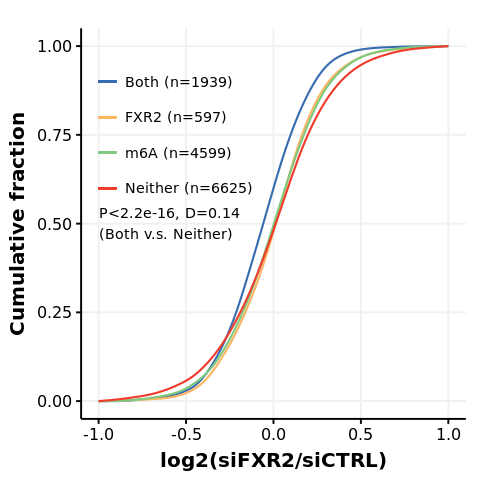

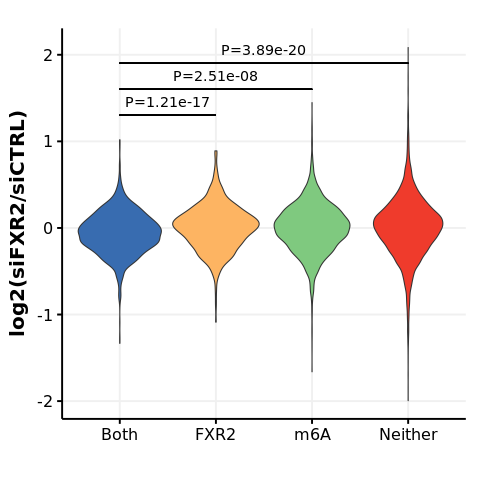

In [587]:
%%R
exp<-read.csv('WGCNA/siFXR2_exp.txt',sep='\t',row.names=1,header=T)
# exp<-exp[exp$FFC!=0,]
exp<-exp[(exp$siFXR2>=1)|(exp$siCTRL>=1),]
exp$Group<-factor(exp$Group,level=c('Both','FXR2','m6A','Neither'))
dens <- density(exp[exp$Group=='Both','FFC'], adjust=1, from=-1, to=1)
dens <- data.frame(x=dens$x, y=dens$y)

dens2<- density(exp[exp$Group=='FXR2','FFC'], adjust=1, from=-1, to=1)
dens2 <- data.frame(x=dens2$x, y=dens2$y)


dens3<- density(exp[exp$Group=='m6A','FFC'], adjust=1, from=-1, to=1)
dens3 <- data.frame(x=dens3$x, y=dens3$y)

dens4<- density(exp[exp$Group=='Neither','FFC'], adjust=1, from=-1, to=1)
dens4 <- data.frame(x=dens4$x, y=dens4$y)

ks_test<-ks.test(exp[exp$Group=='Both','FFC'],exp[exp$Group=='Neither','FFC'])

pdf('figures/Figure5E.pdf',width=7)

p1<-ggplot(exp, aes_string('FFC')) + theme_Publication()+scale_fill_Publication()+
    # geom_density(adjust=1, colour="steelblue4", size=1) +
    geom_line(data=dens, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#386cb0') +
    geom_segment(x = -1, xend = -0.9, y = 0.9,yend = 0.9,color = '#386cb0', size = 1,lty=1)+
    annotate('text',label=paste0('Both (n=',nrow(exp[exp$Group=='Both',]),')'),x=-0.85,y=0.9,hjust=0,size=5)+
    geom_line(data=dens2, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#fdb462') +
    geom_segment(x = -1, xend = -0.9, y = 0.8,yend = 0.8,color = '#fdb462', size = 1,lty=1)+
    annotate('text',label=paste0('FXR2 (n=',nrow(exp[exp$Group=='FXR2',]),')'),x=-0.85,y=0.8,hjust=0,size=5)+
    geom_line(data=dens3, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#7fc97f') +
    geom_segment(x = -1, xend = -0.9, y = 0.7,yend = 0.7,color = '#7fc97f', size = 1,lty=1)+
    annotate('text',label=paste0('m6A (n=',nrow(exp[exp$Group=='m6A',]),')'),x=-0.85,y=0.7,hjust=0,size=5)+
    geom_line(data=dens4, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#ef3b2c') +
    geom_segment(x = -1, xend = -0.9, y = 0.6,yend = 0.6,color = '#ef3b2c', size = 1,lty=1)+
    annotate('text',label=paste0('Neither (n=',nrow(exp[exp$Group=='Neither',]),')'),x=-0.85,y=0.6,hjust=0,size=5)+
    annotate('text',label=paste0('P<2.2e-16, D=',format(ks_test$statistic,scientific=F,digits=2),'\n(Both v.s. Neither)'),x=-1,y=0.5,hjust=0,size=5)+
    ylab('Cumulative fraction') + xlab('log2(siFXR2/siCTRL)') 
print(p1)

pv1<-wilcox.test(exp[exp$Group=='Both','FFC'],exp[exp$Group=='Neither','FFC'])$p.value
pv2<-wilcox.test(exp[exp$Group=='Both','FFC'],exp[exp$Group=='FXR2','FFC'])$p.value
pv3<-wilcox.test(exp[exp$Group=='Both','FFC'],exp[exp$Group=='m6A','FFC'])$p.value

p2<-ggplot(exp,aes_string(x='Group',y='FFC',fill='Group'))+geom_violin(outlier.shape = NA)+theme_Publication()+scale_fill_Publication()+
    geom_segment(x = 1, xend = 4, y = 1.9,yend = 1.9,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv1, scientific = T,digits = 3)),x=2.5,y=2.05,size=5)+
    geom_segment(x = 1, xend = 3, y = 1.6,yend = 1.6,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv2, scientific = T,digits = 3)),x=2,y=1.75,size=5)+
    geom_segment(x = 1, xend = 2, y = 1.3,yend = 1.3,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv3, scientific = T,digits = 3)),x=1.5,y=1.45,size=5)+ylim(-2,2.1)+
    ylab('log2(siFXR2/siCTRL)')+xlab('')+theme(legend.position='none')
print(p2)
dev.off()
print(p1)
print(p2)

# Figure5F

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



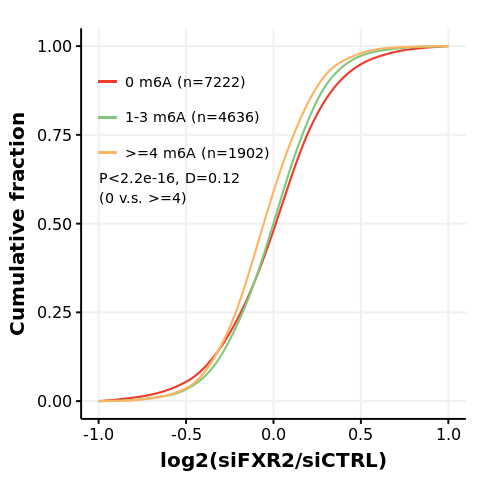

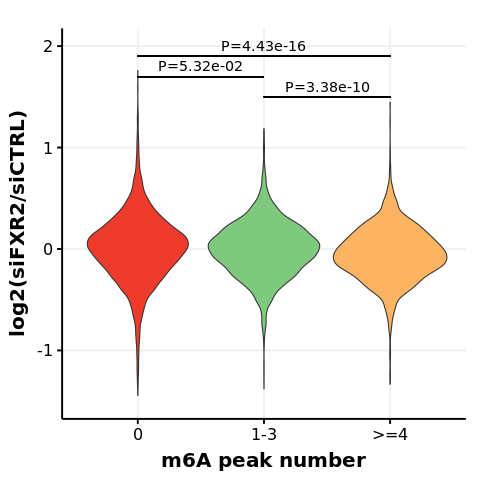

In [586]:
%%R
exp<-read.csv('WGCNA/siFXR2_exp.txt',sep='\t',row.names=1,header=T)
# exp<-exp[exp$FFC!=0,]
exp<-exp[(exp$siFXR2>=1)|(exp$siCTRL>=1),]
range_f<- -1
range_t<- 1
sample2<-'FFC'
ks_test<-ks.test(exp[exp$Peak_num==0,sample2],exp[exp$Peak_num>=4,sample2])
dens2<- density(exp[exp$Peak_num==0,sample2], adjust=1, from=range_f, to=range_t)
dens2 <- data.frame(x=dens2$x, y=dens2$y)

dens3<- density(exp[(exp$Peak_num>=1) & (exp$Peak_num<=3),sample2], adjust=1, from=range_f, to=range_t)
dens3 <- data.frame(x=dens3$x, y=dens3$y)

dens7<- density(exp[exp$Peak_num>=4,sample2], adjust=1, from=range_f, to=range_t)
dens7 <- data.frame(x=dens7$x, y=dens7$y)
pdf('figures/Figure5F.pdf')
p1<-ggplot(exp, aes_string(sample2)) +theme_Publication()+scale_fill_Publication()+
    geom_line(data=dens2, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#ef3b2c') +
    geom_segment(x = -1, xend = -0.9, y = 0.9,yend = 0.9,color = '#ef3b2c', size = 1,lty=1)+
    annotate('text',label=paste0('0 m6A (n=',nrow(exp[exp$Peak_num==0,]),')'),x=-0.85,y=0.9,hjust=0,size=5)+
    geom_line(data=dens3, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#7fc97f') +
    geom_segment(x = -1, xend = -0.9, y = 0.8,yend = 0.8,color = '#7fc97f', size = 1,lty=1)+
    annotate('text',label=paste0('1-3 m6A (n=',nrow(exp[(exp$Peak_num>=1) & (exp$Peak_num<=3),]),')'),x=-0.85,y=0.8,hjust=0,size=5)+
    geom_line(data=dens7, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#fdb462') +
    geom_segment(x = -1, xend = -0.9, y = 0.7,yend = 0.7,color = '#fdb462', size = 1,lty=1)+
    annotate('text',label=paste0('>=4 m6A (n=',nrow(exp[exp$Peak_num>=4,]),')'),x=-0.85,y=0.7,hjust=0,size=5)+
    annotate('text',label=paste0('P<2.2e-16, D=',format(ks_test$statistic,scientific=F,digits=2),'\n(0 v.s. >=4)'),x=-1,y=0.6,hjust=0,size=5)+
    xlab('log2(siFXR2/siCTRL)')+ylab('Cumulative fraction')
print(p1)

exp$Both_sub<-exp$Peak_num

for(i in 1:nrow(exp)){
    if(exp[i,'Peak_num']>=1 && exp[i,'Peak_num']<=3){
        exp[i,'Both_sub']='1-3'
    }else if(exp[i,'Peak_num']>=4){
        exp[i,'Both_sub']='>=4'
    }else if(exp[i,'Peak_num']==0){
        exp[i,'Both_sub']='0'
    }
}

exp$Both_sub<-as.character(exp$Both_sub)
exp$Both_sub<-factor(exp$Both_sub,levels=c('0','1-3','>=4'))
pv1<-wilcox.test(exp[exp$Both_sub=='0',sample2],exp[exp$Both_sub=='>=4',sample2])$p.value
pv2<-wilcox.test(exp[exp$Both_sub=='0',sample2],exp[exp$Both_sub=='1-3',sample2])$p.value
pv3<-t.test(exp[exp$Both_sub=='1-3',sample2],exp[exp$Both_sub=='>=4',sample2])$p.value

p2<-ggplot(exp,aes_string(x='Both_sub',y=sample2,fill='Both_sub'))+geom_violin(outlier.shape=NA)+theme_Publication()+scale_fill_Publication()+
    geom_segment(x = 1, xend = 3, y = 1.9,yend = 1.9,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv1, scientific = T,digits = 3)),x=2,y=2,size=5)+
    geom_segment(x = 1, xend = 2, y = 1.7,yend = 1.7,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv2, scientific = T,digits = 3)),x=1.5,y=1.8,size=5)+
    geom_segment(x = 2, xend = 3, y = 1.5,yend = 1.5,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(pv3, scientific = T,digits = 3)),x=2.5,y=1.6,size=5)+
    ylim(-1.5,2)+ylab('log2(siFXR2/siCTRL)')+xlab('m6A peak number')+theme(legend.position='none')+
    scale_fill_manual(values=c("#ef3b2c", "#7fc97f","#fdb462")) 
print(p2)
dev.off()
print(p1)
print(p2)

# Explore distance between m6A peaks and FXR2 peaks

## Extract distance between m6A and nearest FXR2 peaks

In [ ]:
fxr2_peaks=BedTool('validation/Figure5/FXR2_both.bed')
m6A_peaks=BedTool('validation/Figure5/m6A_both.bed')
closest=m6A_peaks.closest(fxr2_peaks,s=True,t='first',D='a').to_dataframe(names=['chrom','start','end','name','score','strand','b_chrom','b_start','b_end','b_name','b_score','b_strand','distance'])
distance=[]
for x in closest['distance']:
    if x > 0:
        distance.append(x+99)
    elif x < 0:
        distance.append(x-99)
    else:
        distance.append(x)
closest['distance']=distance
closest['ID']=closest[['chrom','start','end','strand']].agg(lambda x:':'.join([str(z) for z in x]),axis=1)
peak_intensity=pd.read_csv('m6A_data/peak_intensity_u8_clam_fc.csv',header=0, index_col=0, sep='\t')
closest['FFC']=[peak_intensity.loc[x,'FFC'] for x in closest['ID']]
closest.to_csv('validation/Figure5/m6A_closest.txt',sep='\t',header=True,index=True)

## Generate random background

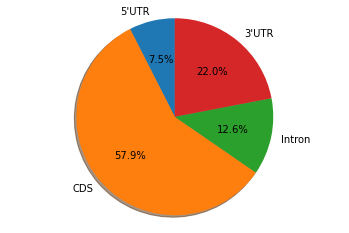

In [462]:
random_times=10000
region_anno={'3UTR':BedTool('gtf/3utr.bed'),'CDS':BedTool('gtf/cds.bed'),'5UTR':BedTool('gtf/5utr.bed'),'Intron':BedTool('gtf/introns.bed')}

fxr2=BedTool('validation/eCLIP/U8.combined.merged.bed')
fxr2_region={}
fxr2_region['CDS']=fxr2.intersect(region_anno['CDS'],s=True,f=0.5,wa=True,u=True)

fxr2_region['3UTR']=fxr2.intersect(region_anno['3UTR'],s=True,f=0.5,wa=True,u=True)
fxr2_region['3UTR']=fxr2_region['3UTR'].subtract(fxr2_region['CDS'],A=True,s=True)

fxr2_region['5UTR']=fxr2.intersect(region_anno['5UTR'],s=True,f=0.5,wa=True,u=True)
fxr2_region['5UTR']=fxr2_region['5UTR'].subtract(fxr2_region['3UTR'],A=True,s=True).subtract(fxr2_region['CDS'],A=True,s=True)

fxr2_region['Intron']=fxr2.intersect(region_anno['Intron'],s=True,f=0.5,wa=True,u=True)
fxr2_region['Intron']=fxr2_region['Intron'].subtract(fxr2_region['CDS'],A=True,s=True).subtract(fxr2_region['3UTR'],A=True,s=True).subtract(fxr2_region['5UTR'],A=True,s=True)
peak_num={}
for region in fxr2_region:
    peak_num[region]=len(fxr2_region[region])
    
labels = "5'UTR", 'CDS', 'Intron', "3'UTR"
sizes = [peak_num[region.replace("'","")] for region in labels]
explode = (0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [509]:
peak_num

{'CDS': 14512, '3UTR': 5509, '5UTR': 1878, 'Intron': 3162}

In [463]:
def get_bin(chr_,start,end,strand,name,bin_size):
    bin_s=start
    ret=[]
    while bin_s < end:
        ret.append([chr_,bin_s,bin_s+bin_size,name,1000,strand])
        bin_s=bin_s+bin_size+1
    return ret
    
valid_genes=list(set(pd.read_csv('validation/Figure5/FXR2_both.bed',sep='\t',header=None).iloc[:,3]))
valid_gene_regions=[]
count=0
for line in open('gtf/hg19.gtf'):
    info=line.strip().split('\t')
    if line.startswith('#') or info[2]!='gene':
        continue
    gene_name=info[-1].split(';')[4].strip().split(' ')[1].replace('"','')
    if gene_name in valid_genes:
        count+=1
        valid_gene_regions.extend(get_bin(info[0],int(info[3]),int(info[4]),info[6],gene_name,100))
valid_gene_regions=pd.DataFrame(valid_gene_regions)
valid_gene_regions=BedTool.from_dataframe(valid_gene_regions)

random_regions={}
random_regions['CDS']=valid_gene_regions.intersect(region_anno['CDS'],s=True,f=0.5,wa=True,u=True)

random_regions['3UTR']=valid_gene_regions.intersect(region_anno['3UTR'],s=True,f=0.5,wa=True,u=True)
random_regions['3UTR']=random_regions['3UTR'].subtract(random_regions['CDS'],A=True,s=True)

random_regions['5UTR']=valid_gene_regions.intersect(region_anno['5UTR'],s=True,f=0.5,wa=True,u=True)
random_regions['5UTR']=random_regions['5UTR'].subtract(random_regions['3UTR'],A=True,s=True).subtract(random_regions['CDS'],A=True,s=True)

random_regions['Intron']=valid_gene_regions.intersect(region_anno['Intron'],s=True,f=0.5,wa=True,u=True)
random_regions['Intron']=random_regions['Intron'].subtract(random_regions['CDS'],A=True,s=True).subtract(random_regions['3UTR'],A=True,s=True).subtract(random_regions['5UTR'],A=True,s=True)

for region in random_regions:
    random_regions[region]=random_regions[region].to_dataframe()

In [464]:
def random_draw_region(peak_num,random_regions):
    ret={}
    for region in peak_num:
        ret[region]=random_regions[region].sample(n=peak_num[region])
    return ret

peak_intensity=pd.read_csv('m6A_data/peak_intensity_u8_clam_fc.csv',header=0, index_col=0, sep='\t')
m6A_peaks=BedTool('validation/Figure5/m6A_both.bed')

rand_distance=None
for n in range(random_times):
    rand=BedTool.from_dataframe(random_regions[region].sample(n=peak_num[region])).sort()
    
    closest=m6A_peaks.closest(rand,s=True,t='first',D='a').to_dataframe(names=['chrom','start','end','name','score','strand','b_chrom','b_start','b_end','b_name','b_score','b_strand','distance'])
    distance=[]
    for x in closest['distance']:
        if x > 0:
            distance.append(math.log10(x+99))
        elif x < 0:
            distance.append(-math.log10(-x+99))
        else:
            distance.append(x)
    closest['distance']=distance
    closest['ID']=closest[['chrom','start','end','strand']].agg(lambda x:':'.join([str(z) for z in x]),axis=1)
    closest.index=closest['ID']
    closest=closest[['distance']]
    closest.columns=['distance_%s'%n]
    if rand_distance is None:
        rand_distance=closest
    else:
        rand_distance=pd.concat([rand_distance,closest],axis=1)
rand_distance['low']=rand_distance.iloc[:,range(random_times)].quantile(q=0.1, axis=1)
rand_distance['median']=rand_distance.iloc[:,range(random_times)].median(axis=1)
rand_distance['high']=rand_distance.iloc[:,range(random_times)].quantile(q=0.9, axis=1)
rand_distance.to_csv('validation/Figure5/random_distance.txt',sep='\t',header=True,index=True)
# .iloc[:,[random_times,random_times+1,random_times+2]]

## GO enrichment of m6A/gene up/down 

In [643]:
threshold=0
ensg_gn={x[1]:x[0] for x in [y.strip().split('\t') for y in open('gtf/ensg_gn.txt')]}
m6a_closest=pd.read_csv('validation/Figure5/m6A_closest.txt',header=0,index_col=0,sep='\t')
m6a_closest['id']=[ensg_gn[x] if x in ensg_gn else np.nan for x in m6a_closest['name']]
m6a_up=m6a_closest.loc[m6a_closest['FFC']>threshold,'id'].drop_duplicates().dropna()
m6a_down=m6a_closest.loc[m6a_closest['FFC']<-threshold,'id'].drop_duplicates().dropna()
gene_exp=pd.read_csv('WGCNA/siFXR2_exp.txt',header=0,index_col=0,sep='\t')
gene_exp['gene']=[ensg_gn[x] if x in ensg_gn else np.nan for x in gene_exp.index]
gene_up=gene_exp.loc[gene_exp['FFC']>threshold,'gene'].drop_duplicates().dropna()
gene_down=gene_exp.loc[gene_exp['FFC']<-threshold,'gene'].drop_duplicates().dropna()

m6a_up.to_csv('validation/Figure5/GO_m6a_up.txt',header=False,index=False)
m6a_down.to_csv('validation/Figure5/GO_m6a_down.txt',header=False,index=False)
gene_up.to_csv('validation/Figure5/GO_gene_up.txt',header=False,index=False)
gene_down.to_csv('validation/Figure5/GO_gene_down.txt',header=False,index=False)
subprocess.call('python3 scripts/hyper_geometry.py validation/Figure5/GO_m6a_up.txt validation/Figure5/GO_m6a_down.txt validation/Figure5/GO_gene_up.txt validation/Figure5/GO_gene_down.txt',shell=True)

null device 
          1 


0

## Compare distribution of distance between m6A peaks up and down regulated

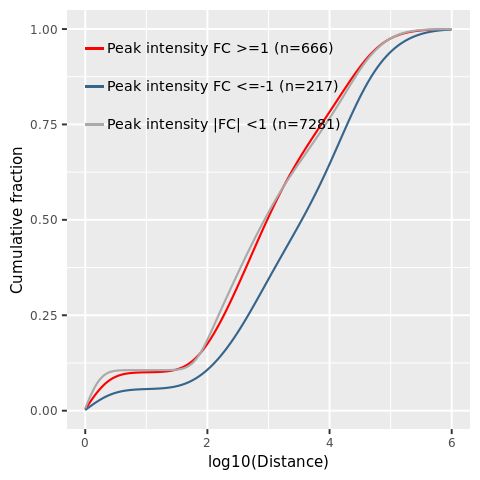

In [590]:
%%R
distance<-read.table('validation/Figure5/m6A_closest.txt',row.names=1)
# distance$distance<-distance$distance/100 # Our peaks were called by bins with width=100, distance can only be (+-)(N*100+1), no values between 1-100
distance[distance$distance>0,]$distance<-log10(distance[distance$distance>0,]$distance)
distance[distance$distance<0,]$distance<- -log10(-distance[distance$distance<0,]$distance)

distance$abs_distance<-abs(distance$distance)
distance_p<-distance[distance$FFC>= 1,]
distance_n<-distance[distance$FFC<= -1,]
distance_0<-distance[(distance$FFC<1) & (distance$FFC> -1),]

e = 0.3 * diff(range(distance_p$abs_distance))
dens_p = density(distance_p$abs_distance, adjust=1, from=0, to=max(distance_p$abs_distance) +e)
dens_p = data.frame(x=dens_p$x, y=dens_p$y)


e = 0.3 * diff(range(distance_n$abs_distance))
dens_n = density(distance_n$abs_distance, adjust=1, from=0, to=max(distance_n$abs_distance) +e)
dens_n = data.frame(x=dens_n$x, y=dens_n$y)


e = 0.3 * diff(range(distance_0$abs_distance))
dens_0 = density(distance_0$abs_distance, adjust=1, from=0, to=max(distance_0$abs_distance) +e)
dens_0 = data.frame(x=dens_0$x, y=dens_0$y)

p<-ggplot(data=dens_p, aes(x=x, y=cumsum(y)/sum(y))) + 
    xlab('log10(Distance)')+ylab('Cumulative fraction')+xlim(0,6)+
    geom_line(data=dens_p, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='red') +
    geom_line(data=dens_n, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='steelblue4') +
    geom_line(data=dens_0, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='darkgrey') +

    geom_segment(x = 0, xend = 0.3, y = 0.95,yend = 0.95,color = 'red', size = 1,lty=1)+
    geom_segment(x = 0, xend = 0.3, y = 0.85,yend = 0.85,color = 'steelblue4', size = 1,lty=1)+
    geom_segment(x = 0, xend = 0.3, y = 0.75,yend = 0.75,color = 'darkgrey', size = 1,lty=1)+
    annotate('text',label=paste0('Peak intensity FC >=1 (n=',nrow(distance_p),')'),x=0.35,y=0.95,hjust=0,size=5)+
    annotate('text',label=paste0('Peak intensity FC <=-1 (n=',nrow(distance_n),')'),x=0.35,y=0.85,hjust=0,size=5)+
    annotate('text',label=paste0('Peak intensity |FC| <1 (n=',nrow(distance_0),')'),x=0.35,y=0.75,hjust=0,size=5)+
#     annotate('text',label=paste0('P=',format(ks.test(x=distance_p$abs_distance,y=distance_n$abs_distance)$p.value,scientific=T,digits=3),' (K-S test)'),x=0,y=0.75,hjust=0,size=5)+
    theme(
        text = element_text(size=15)
    )
print(p)


[1] 7281
[1] 217
[1] 666


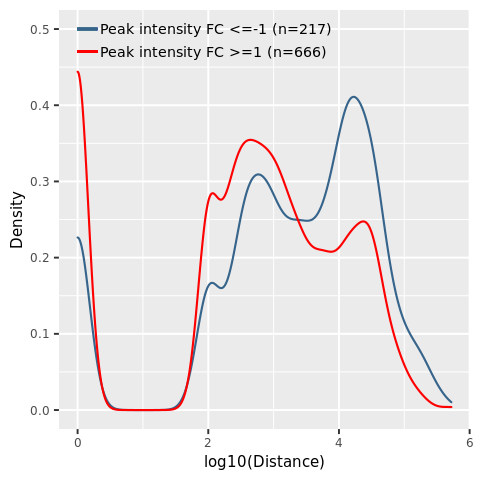

In [539]:
%%R
distance_p<-distance[distance$FFC>= 1,]
distance_n<-distance[distance$FFC<= -1,]
distance_0<-distance[(distance$FFC<1) & (distance$FFC> -1),]

p<-ggplot(data=distance_n, aes(abs_distance)) + 
    geom_density(data=distance_n, aes(abs_distance),adjust=.5, colour="steelblue4", size=1,n=1024) +
    geom_density(data=distance_p, aes(abs_distance),adjust=.5, colour="red", size=1,n=1024) +
    
    xlab('log10(Distance)')+ylab('Density')+ylim(0,0.5)+

    geom_segment(x = 0, xend = 0.3, y = 0.47,yend = 0.47,color = 'red', size = 1,lty=1)+
    geom_segment(x = 0, xend = 0.3, y = 0.5,yend = 0.5,color = 'steelblue4', size = 1,lty=1)+
    annotate('text',label=paste0('Peak intensity FC >=1 (n=',nrow(distance_p),')'),x=0.35,y=0.47,hjust=0,size=5)+
    annotate('text',label=paste0('Peak intensity FC <=-1 (n=',nrow(distance_n),')'),x=0.35,y=0.5,hjust=0,size=5)+

    theme(
        text = element_text(size=15)
    )
print(p)
# print(nrow(distance))
print(nrow(distance_0))
print(nrow(distance_n))
print(nrow(distance_p))

## Use 1000 bp as threshold to separate group Both into Both_Proximal and Both_Distal

In [545]:
%%R
exp<-read.csv('WGCNA/siFXR2_exp.txt',sep='\t',row.names=1,header=T)
gene_distance<-c()
for(i in seq(1:nrow(distance))){
    if(distance[i,4] %in% names(gene_distance)){
        if(gene_distance[distance[i,4]] < distance[i,16]){
            gene_distance[distance[i,4]]<-distance[i,16]
        }
    }else{
        gene_distance[distance[i,4]]<-distance[i,16]
    }
}
type_<-list()
for(i in seq(1:nrow(exp))){
    if(rownames(exp)[i] %in% names(gene_distance)){
        if(gene_distance[rownames(exp)[i]]==0){
            type_<-append(type_,'Overlapping')
        }else{
            type_<-append(type_,'Around')
        }
    }else{
        type_<-append(type_,'NA')
    }
}
exp$Sub_grp<-type_
exp$Group = ifelse(exp$Sub_grp == 'NA', exp$Group, exp$Sub_grp)

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



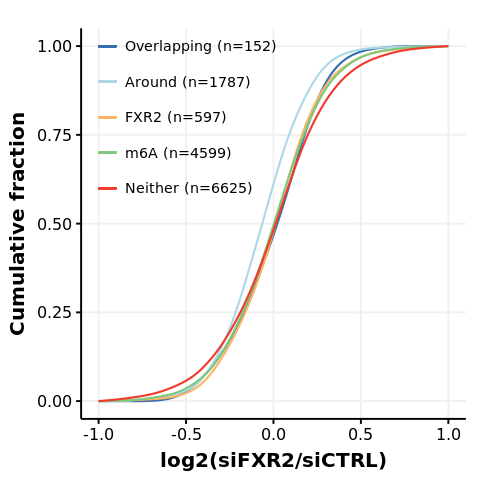

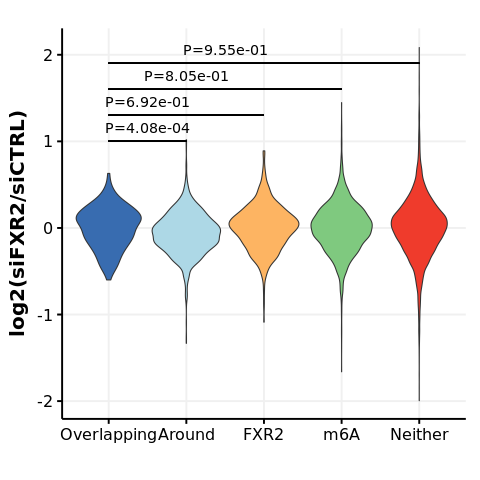

In [548]:
%%R
exp<-exp[(exp$siFXR2>=1)|(exp$siCTRL>=1),]
exp$Group<-factor(exp$Group,level=c('Overlapping','Around','FXR2','m6A','Neither'))
dens <- density(exp[exp$Group=='Overlapping','FFC'], adjust=1, from=-1, to=1)
dens <- data.frame(x=dens$x, y=dens$y)

dens1 <- density(exp[exp$Group=='Around','FFC'], adjust=1, from=-1, to=1)
dens1 <- data.frame(x=dens1$x, y=dens1$y)

dens2<- density(exp[exp$Group=='FXR2','FFC'], adjust=1, from=-1, to=1)
dens2 <- data.frame(x=dens2$x, y=dens2$y)


dens3<- density(exp[exp$Group=='m6A','FFC'], adjust=1, from=-1, to=1)
dens3 <- data.frame(x=dens3$x, y=dens3$y)

dens4<- density(exp[exp$Group=='Neither','FFC'], adjust=1, from=-1, to=1)
dens4 <- data.frame(x=dens4$x, y=dens4$y)

# pdf('figures/cdf_exp_both_m6a.pdf',width=7)

p<-ggplot(exp, aes_string('FFC')) + theme_Publication()+scale_fill_Publication()+
    # geom_density(adjust=1, colour="steelblue4", size=1) +
    geom_line(data=dens, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#386cb0') +
    geom_segment(x = -1, xend = -0.9, y = 1,yend = 1,color = '#386cb0', size = 1,lty=1)+
    annotate('text',label=paste0('Overlapping (n=',nrow(exp[exp$Group=='Overlapping',]),')'),x=-0.85,y=1,hjust=0,size=5)+

    geom_line(data=dens1, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='lightblue') +
    geom_segment(x = -1, xend = -0.9, y = 0.9,yend = 0.9,color = 'lightblue', size = 1,lty=1)+
    annotate('text',label=paste0('Around (n=',nrow(exp[exp$Group=='Around',]),')'),x=-0.85,y=0.9,hjust=0,size=5)+

    geom_line(data=dens2, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#fdb462') +
    geom_segment(x = -1, xend = -0.9, y = 0.8,yend = 0.8,color = '#fdb462', size = 1,lty=1)+
    annotate('text',label=paste0('FXR2 (n=',nrow(exp[exp$Group=='FXR2',]),')'),x=-0.85,y=0.8,hjust=0,size=5)+

    geom_line(data=dens3, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#7fc97f') +
    geom_segment(x = -1, xend = -0.9, y = 0.7,yend = 0.7,color = '#7fc97f', size = 1,lty=1)+
    annotate('text',label=paste0('m6A (n=',nrow(exp[exp$Group=='m6A',]),')'),x=-0.85,y=0.7,hjust=0,size=5)+

    geom_line(data=dens4, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='#ef3b2c') +
    geom_segment(x = -1, xend = -0.9, y = 0.6,yend = 0.6,color = '#ef3b2c', size = 1,lty=1)+
    annotate('text',label=paste0('Neither (n=',nrow(exp[exp$Group=='Neither',]),')'),x=-0.85,y=0.6,hjust=0,size=5)+
    ylab('Cumulative fraction') + xlab('log2(siFXR2/siCTRL)') 
print(p)

p1<-wilcox.test(exp[exp$Group=='Overlapping','FFC'],exp[exp$Group=='Neither','FFC'])$p.value
p2<-wilcox.test(exp[exp$Group=='Overlapping','FFC'],exp[exp$Group=='FXR2','FFC'])$p.value
p3<-wilcox.test(exp[exp$Group=='Overlapping','FFC'],exp[exp$Group=='m6A','FFC'])$p.value
p4<-wilcox.test(exp[exp$Group=='Overlapping','FFC'],exp[exp$Group=='Around','FFC'])$p.value

p<-ggplot(exp,aes_string(x='Group',y='FFC',fill='Group'))+geom_violin(outlier.shape = NA)+theme_Publication()+scale_fill_Publication()+
    geom_segment(x = 1, xend = 5, y = 1.9,yend = 1.9,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(p1, scientific = T,digits = 3)),x=2.5,y=2.05,size=5)+

    geom_segment(x = 1, xend = 4, y = 1.6,yend = 1.6,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(p2, scientific = T,digits = 3)),x=2,y=1.75,size=5)+

    geom_segment(x = 1, xend = 3, y = 1.3,yend = 1.3,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(p3, scientific = T,digits = 3)),x=1.5,y=1.45,size=5)+ylim(-2,2.1)+

    geom_segment(x = 1, xend = 2, y = 1,yend = 1,color = 'black', size = 0.5,lty=1)+
    annotate('text',label=paste0('P=',format(p4, scientific = T,digits = 3)),x=1.5,y=1.15,size=5)+ylim(-2,2.1)+

    ylab('log2(siFXR2/siCTRL)')+xlab('')+theme(legend.position='none')+  scale_fill_manual(values = c("#386cb0",'lightblue',"#fdb462","#7fc97f","#ef3b2c"))
print(p)
# dev.off()

## Explore distribution of distance 

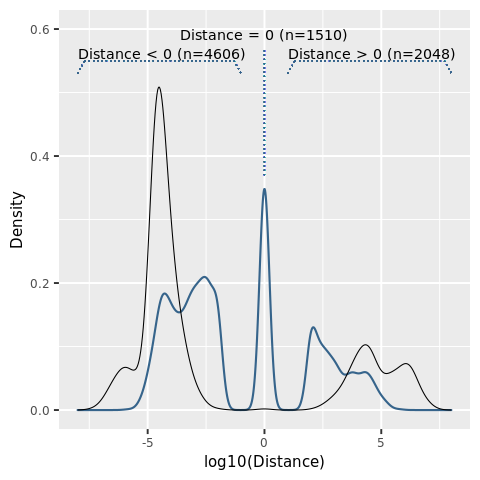

In [512]:
%%R
distance<-read.table('validation/Figure5/m6A_closest.txt',row.names=1)
# distance$distance<-distance$distance/100 # Our peaks were called by bins with width=100, distance can only be (+-)(N*100+1), no values between 1-100
distance[distance$distance>0,]$distance<-log10(distance[distance$distance>0,]$distance)
distance[distance$distance<0,]$distance<- -log10(-distance[distance$distance<0,]$distance)

distance$abs_distance<-abs(distance$distance)

e = 0.3 * diff(range(distance$distance))
range_f=min(distance$distance)-e
range_t=max(distance$distance) +e
dens = density(distance$distance, adjust=0.5, from=range_f, to=range_t)
dens = data.frame(x=dens$x, y=dens$y)

rand<-read.table('validation/Figure5/random_distance.txt',header=T)

# dens_l = density(rand$low, adjust=0.5, from=min(distance$distance)-e, to=max(distance$distance) +e)
# dens_l = data.frame(x=dens_l$x, y=dens_l$y)

# dens_h = density(rand$high, adjust=0.5, from=min(distance$distance)-e, to=max(distance$distance) +e)
# dens_h = data.frame(x=dens_h$x, y=dens_h$y)

dens_m = density(rand$median, adjust=0.5, from=min(distance$distance)-e, to=max(distance$distance) +e)
dens_m = data.frame(x=dens_m$x, y=dens_m$y)

p<-ggplot(distance, aes(distance)) +xlim(-8,8)+ 
    geom_density(adjust=.5, colour="steelblue4", size=1,n=1024) +xlab('log10(Distance)')+ylim(0,0.6)+ylab('Density')+
    geom_segment(x = -8, xend = -7.7, y = 0.53,yend = 0.55,color = 'steelblue4', size = 0.5,lty=3)+
    geom_segment(x = -7.7, xend = -1.3, y = 0.55,yend = 0.55,color = 'steelblue4', size = 0.5,lty=3)+
    geom_segment(x = -1.3, xend = -1, y = 0.55,yend = 0.53,color = 'steelblue4', size = 0.5,lty=3)+
    annotate('text',label=paste0('Distance < 0 (n=',nrow(distance[distance$distance<0,]),')'),x=-8,y=0.56,hjust=0,size=5)+

    geom_segment(x = 1, xend = 1.3, y = 0.53,yend = 0.55,color = 'steelblue4', size = 0.5,lty=3)+
    geom_segment(x = 1.3, xend = 7.7, y = 0.55,yend = 0.55,color = 'steelblue4', size = 0.5,lty=3)+
    geom_segment(x = 7.7, xend = 8, y = 0.55,yend = 0.53,color = 'steelblue4', size = 0.5,lty=3)+
    annotate('text',label=paste0('Distance > 0 (n=',nrow(distance[distance$distance>0,]),')'),x=1,y=0.56,hjust=0,size=5)+

    geom_segment(x = 0, xend = 0, y = 0.37,yend = 0.57,color = 'steelblue4', size = 0.5,lty=3)+
    annotate('text',label=paste0('Distance = 0 (n=',nrow(distance[distance$distance==0,]),')'),x=0,y=0.59,hjust=0.5,size=5)+

    geom_line(data=dens_m,aes(x=x,y=y))+
#     geom_line(data=dens_h,aes(x=x,y=y))+xlim(-6,6)+
    theme(
        text = element_text(size=15)
    )
print(p)

# p<-ggplot(distance,aes(distance))+
#     geom_line(data=dens, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='steelblue4')+
# # geom_line(data=dens_l, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='steelblue4')+
# geom_line(data=dens_m, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='black')
# # geom_line(data=dens_h, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='darkgrey')
# print(p)

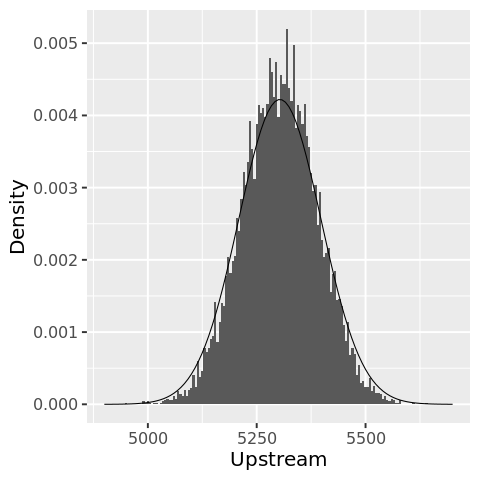

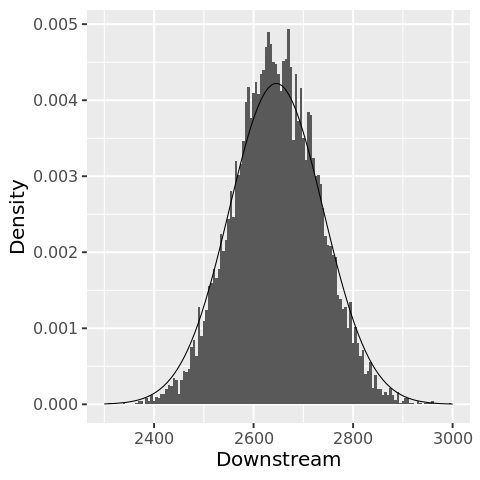

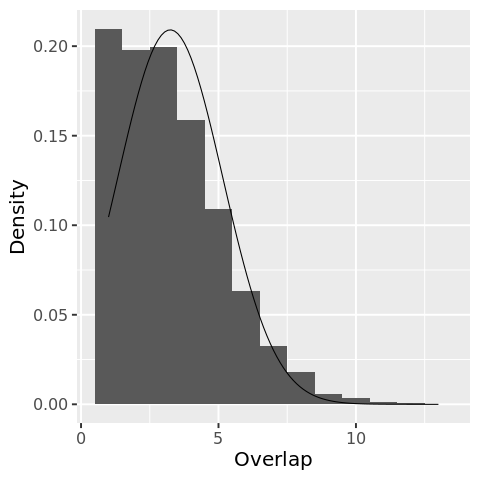

In [511]:
%%R
rownames(rand)<-rand$ID
rand <- subset(rand, select = -c(ID))
CountUp<-function(list_){
     length(list_[list_<0])
}
CountDown<-function(list_){
     length(list_[list_>0])
}
CountOL<-function(list_){
     length(list_[list_==0])
}
rand['Downstream',]<-apply(rand,MARGIN=2,CountDown)
rand['Overlap',]<-apply(rand,MARGIN=2,CountOL)
rand['Upstream',]<-apply(rand,MARGIN=2,CountUp)
rand_t<-as.data.frame(t(rand))
p1<-ggplot(rand_t,aes(Upstream))+geom_histogram(aes(y =..density..),binwidth=5)+xlim(4900,5700) +
    stat_function(fun = dnorm, args = list(mean = mean(rand_t$Upstream), sd = sd(rand_t$Upstream)))+ylab('Density')
p2<-ggplot(rand_t,aes(Downstream))+geom_histogram(aes(y =..density..),binwidth=5)+xlim(2300,3000)+
    stat_function(fun = dnorm, args = list(mean = mean(rand_t$Downstream), sd = sd(rand_t$Downstream)))+ylab('Density')
p3<-ggplot(rand_t,aes(Overlap))+geom_histogram(aes(y =..density..),binwidth=1)+
    stat_function(fun = dnorm, args = list(mean = mean(rand_t$Overlap), sd = sd(rand_t$Overlap)))+ylab('Density')
print(p1)
print(p2)
print(p3)

In [513]:
%%R
fit_d<-fitdistr(rand_t$Downstream,'normal')
print(pnorm(2048, mean = fit_d$estimate[1], sd = fit_d$estimate[2]))
print(fit_d$estimate)
fit_u<-fitdistr(rand_t$Upstream,'normal')
print(pnorm(4606, mean = fit_u$estimate[1], sd = fit_u$estimate[2]))
print(fit_u$estimate)
fit_o<-fitdistr(rand_t$Overlap,'gamma')
print(1-pnorm(1510, mean = fit_o$estimate[1], sd = fit_o$estimate[2]))
print(fit_o$estimate)

[1] 1.277228e-10
      mean         sd 
2645.53434   94.49191 
[1] 8.060679e-14
     mean        sd 
5303.2195   94.5054 
[1] 0
    shape      rate 
2.8487751 0.8775923 


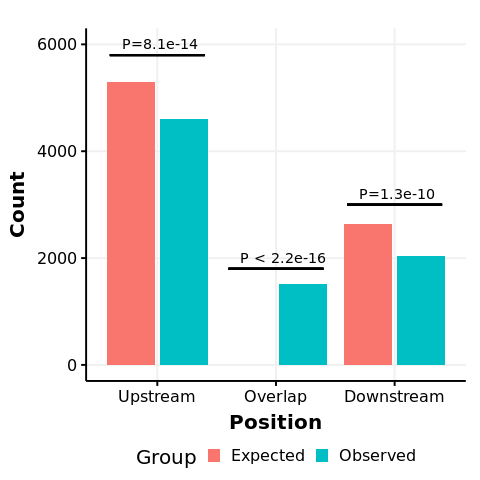

In [534]:
%%R
dt<-t(data.frame(Expected=c(round(fit_u$estimate[1]),round(fit_o$estimate[1]),round(fit_d$estimate[1])),
                 Observed=c(nrow(distance[distance$distance<0,]),
                            nrow(distance[distance$distance==0,]),
                            nrow(distance[distance$distance>0,]))))
      
colnames(dt)<-c('Upstream','Overlap','Downstream')
pvalue<-fisher.test(dt[,c('Upstream','Downstream')])$p.value
dt_m<-melt(dt)
colnames(dt_m)<-c('Group','Position','Count')
p<-ggplot(dt_m,aes(x=Position,y=Count,group=Group,fill=Group))+geom_bar(stat = "identity",position = "dodge2")+ylim(0,6000)+theme_Publication()+
    geom_segment(x = 0.6, xend = 1.4, y = 5800,yend = 5800,color = 'black', size = 1,lty=1)+
    annotate('text',label=paste0('P=',format(pnorm(4606, mean = fit_u$estimate[1], sd = fit_u$estimate[2]),scientific=T,digits=2)),x=0.7,y=6000,hjust=0,size=5)+
    geom_segment(x = 1.6, xend = 2.4, y = 1800,yend = 1800,color = 'black', size = 1,lty=1)+
    annotate('text',label=paste0('P < 2.2e-16'),x=1.7,y=2000,hjust=0,size=5)+
    geom_segment(x = 2.6, xend = 3.4, y = 3000,yend = 3000,color = 'black', size = 1,lty=1)+
    annotate('text',label=paste0('P=',format(pnorm(2048, mean = fit_d$estimate[1], sd = fit_d$estimate[2]),scientific=T, digits=2)),x=2.7,y=3200,hjust=0,size=5)
print(p)

In [501]:
%%R
print(dt)
fisher.test(dt[,c('Upstream','Downstream')])

         Upstream Overlap Downstream
Expected     5303       3       2643
Observed     4606    1510       2048

	Fisher's Exact Test for Count Data

data:  dt[, c("Upstream", "Downstream")]
p-value = 0.001447
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8313377 0.9573043
sample estimates:
odds ratio 
 0.8921426 



In [503]:
%%R
dx<-t(data.frame(Expected=c(5304,2672),
                 Observed=c(nrow(distance[distance$distance<0,]),
                            nrow(distance[distance$distance>0,]))))
fisher.test(dx)


	Fisher's Exact Test for Count Data

data:  dx
p-value = 0.0004677
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8225859 0.9469681
sample estimates:
odds ratio 
 0.8826271 



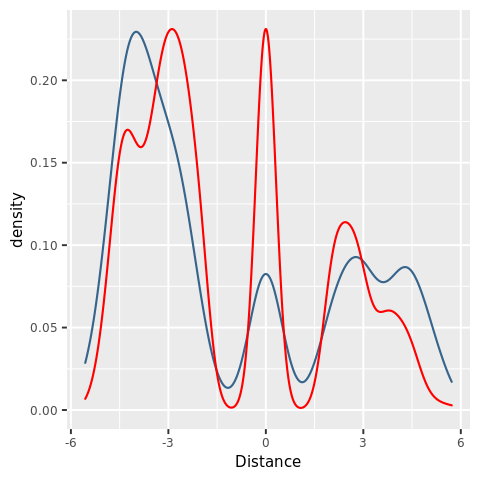

In [12]:
%%R
distance_p<-distance[distance$FFC> 1,]
distance_n<-distance[distance$FFC< -1,]
distance_0<-distance[(distance$FFC<=1) && (distance$FFC>= -1),]


e = 0.3 * diff(range(distance_p$distance))
dens_p = density(distance_p$distance, adjust=1, from=min(distance_p$distance)-e, to=max(distance_p$distance) +e)
dens_p = data.frame(x=dens_p$x, y=dens_p$y)


e = 0.3 * diff(range(distance_n$distance))
dens_n = density(distance_n$distance, adjust=1, from=min(distance_n$distance)-e, to=max(distance_n$distance) +e)
dens_n = data.frame(x=dens_n$x, y=dens_n$y)

e = 0.3 * diff(range(distance_0$distance))
dens_0 = density(distance_0$distance, adjust=1, from=min(distance_0$distance)-e, to=max(distance_0$distance) +e)
dens_0 = data.frame(x=dens_0$x, y=dens_0$y)

p<-ggplot() + 
    geom_density(data=distance_n, aes(distance),adjust=.5, colour="steelblue4", size=1,n=1024) +
    geom_density(data=distance_p, aes(distance),adjust=.5, colour="red", size=1,n=1024) +
#     geom_density(data=distance_0, aes(distance),adjust=.5, colour="darkgrey", size=1,n=1024) +
    xlab('Distance')+
#     geom_line(data=dens_p, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='lightpink3') +
#     geom_line(data=dens_n, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='lightblue') +
    theme(
        text = element_text(size=15)
    )
print(p)


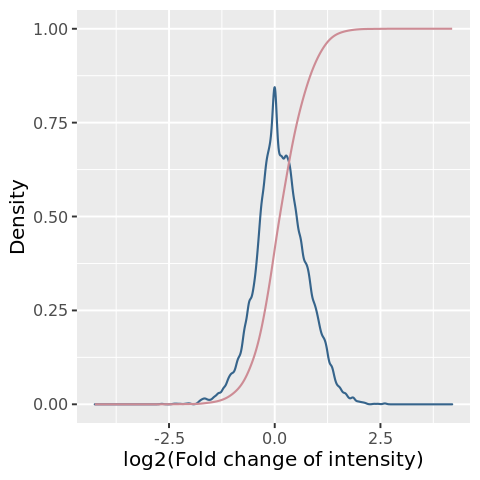

In [269]:
%%R
e = 0.3 * diff(range(distance$FFC))
dens = density(distance$FFC, adjust=1, from=min(distance$FFC)-e, to=max(distance$FFC) +e)
dens = data.frame(x=dens$x, y=dens$y)

ggplot() + 
    geom_density(data=distance, aes(FFC),adjust=.5, colour="steelblue4", size=1,n=1024) +ylab('Density')+xlab('log2(Fold change of intensity)')+
    geom_line(data=dens, aes(x=x, y=cumsum(y)/sum(y)), size=1, colour='lightpink3') 